In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# coding=utf-8

# Análisis áreas - Intento desde limpio

## Funciones área

In [3]:
def tauAreaMax(iAMC, prop= 0.25, rechazo= 0.05):
    '''
    (array, array) -> array
    T: vector tiempos
    Meas2: array (2,:) con Meas2[0] canal 1, Meas2[0] canal 2, producto de np.vstack

    Retorna:
    índice vector tiempo subida entre 10% y 90% canal 2 (ch2: AMC)
    Área total: por sobre nivel de base entre 10% a izquierda y derecha (ch2: AMC)
    Área subida: por sobre nivel de base entre 10% a izquierda y máximo (ch2: AMC)
    Máximo (ch2: AMC)
    '''
    maxIx= iAMC.argmax() # índice máximo
    # máximo promediado cercano
    rangoCercano= 20 # tres lecturas a izq y derecha
    iAMCMax= (iAMC[maxIx- rangoCercano: maxIx+ rangoCercano]).mean()   

    erstePunkten= int(iAMC.size* prop)
    ch2Erste= iAMC[0:erstePunkten-1]
    iAMCProm= ch2Erste.mean()
    
    if (ch2Erste.std() > (np.abs((iAMCMax- iAMCProm )* rechazo))): # desvio standard AMC> (máximo- nivel base) * rechazo
        return np.zeros(4) # cuidar que tenga igual dimensión que salida
    else:
        # diferencia máximo- base
        difMaxMin= iAMCMax- iAMCProm # usa promediado cercano
        # Diferencias de potencial para 10%, 90% de excursión
        v10= iAMCProm+ 0.1* difMaxMin
        v90= iAMCProm+ 0.9* difMaxMin
        # Índices para primer potencial del pulso que exceda 10%, y último por debajo 90% 
        ixTauiAMC= np.array([maxIx, maxIx])
        while (iAMC[ixTauiAMC[0]]> v10):
            ixTauiAMC[0]-= 1
        while (iAMC[ixTauiAMC[1]]> v90):
            ixTauiAMC[1]-= 1
        iAMCTau= ixTauiAMC[1]- ixTauiAMC[0] # el vector 
        # Area
        ixAMC10ProzentRicht= maxIx # empiezo por máximo
        while (iAMC[ixAMC10ProzentRicht]> v10):
            ixAMC10ProzentRicht+= 1
        # ixTau[1], maxIx[1], ixAMC10ProzentRicht
        # hay que sumar diferencia AMC con este nivel desde el índice 10% izquierda hasta derecha
        iAMCAreaSubida= (iAMC[ixTauiAMC[0]: maxIx] - iAMCProm).sum()
        iAMCAreaTotal= iAMCAreaSubida+ (iAMC[maxIx+ 1: ixAMC10ProzentRicht] - iAMCProm).sum()
        return np.array([iAMCTau, iAMCMax, iAMCAreaSubida, iAMCAreaTotal])

In [4]:
def conversionV(npzData):
    """ acq -> np.array: [ceroAMCPto, pasoVerticalAMCVoltPto, ceroFLUCPto, pasoVerticalFLUCVoltPto]

    Da factores de conservión para de Meas2 con niveles en enteros obtener niveles en potencial eléctrico.
    e.g. potencialAMC= (Meas2[1,:]- ceroAMCPto)* pasoVerticalAMCVoltPto
    
    >>> conversionV(acq)
    'olleh'
    """
    # Constructivo del Tek 2002B
    divVert= 8 # numero de divisiones verticales
    divHoriz= 10
    ptosVert= 2**8 # 8 bits definición vertical
    ptosHoriz= 2500
    # npZData.items() # lista los elementos en el archivo de aquisición en memoria
    settingsList= npzData['settings'].tolist()
    
    # Vertical (potencial)
    escalaFLUCVoltsDiv= settingsList['SCALE1'] # [V/div]
    pasoVerticalFLUCVoltPto= escalaFLUCVoltsDiv* divVert/ ptosVert # [V/div]
    escalaAMCVoltsDiv= settingsList['SCALE2'] # [V/div]
    pasoVerticalAMCVoltPto= escalaAMCVoltsDiv* divVert/ ptosVert # [V/div]
    ceroFLUCDiv= settingsList['POSITION1'] # [div]
    ceroFLUCPto= ceroFLUCDiv* divVert/ ptosVert # [ptos]
    ceroAMCDiv= settingsList['POSITION2'] # [div]
    ceroAMCPto= ceroAMCDiv* ptosVert/ divVert # [ptos]
    
    return ceroAMCPto, pasoVerticalAMCVoltPto, ceroFLUCPto, pasoVerticalFLUCVoltPto

In [5]:
def agrupadorTauMaxAreas(npzData, prop=0.25):
    '''
    (npzData) -> (array)
    recorre todas las adquisiciones en npzData
    
    entrega array con filas [tauAMCi, tauFLUCi, areaTotalAMCi, areaSubidaAMCi, maxAMCi]
    '''
    T= npzData['zeit']
    AMC= npzData['ch2']
    messungenZahl= AMC.shape
    numAdq= messungenZahl[0] # numero de adquisiciones en npzData
    finales= np.empty([numAdq,4])
    validas=0
    
    # conversión
    pasoT= T[1]-T[0]
    ceroAMCPto, pasoVerticalAMCVoltPto, ceroFLUCPto, pasoVerticalFLUCVoltPto= conversionV(npzData)
    
    for adqActual in range(numAdq):
        iAMC= AMC[adqActual]
        # print(adqActual)
        # parciales=  tauAreaMax(iAMC)
        # parciales[0]*= pasoT
        try: # IndexError: index out of bounds
            parciales=  tauAreaMax(iAMC)# np.array([ixTauiAMC, iAMCMax, iAMCAreaSubida, iAMCAreaTotal]) [cuentas]
            parciales[0]*= pasoT # ixTauiAMC [s]
            parciales[1]= (parciales[1]- ceroAMCPto)* pasoVerticalAMCVoltPto # iAMCMax [V]
            parciales[2]= (parciales[2]- messungenZahl[1]* ceroAMCPto)* pasoT # iAMCAreaSubida [Vs] <anl150907>
            parciales[3]= (parciales[3]- messungenZahl[1]* ceroAMCPto)* pasoT # iAMCAreaTotal [Vs] <anl150907>
        except IndexError:
            parciales= np.zeros(4)
        # print(parciales[0], parciales)
        if (parciales[0]>0):
            # print(validas, parciales[0], parciales[3])
            finales[validas]= parciales
            validas+=1
    finales= finales[0:-(numAdq-validas)]
    return finales

In [6]:
def desvioEstandardCuasiNoSesgado(datos):
    '''
    Estimador cuasi no sesgado de la desviación estandar.
    https://en.wikipedia.org/wiki/Unbiased_estimation_of_standard_deviation
    '''
    media= np.mean(datos)
    suma=0
    for i in datos:
        aux= (datos[i]- media)
        suma+= aux**2
    desv= np.sqrt(suma/( np.size(datos)- 1.5) ) 
    return desv


def errorEstandard(datos):
    '''
    Estimador de la desviación estandar del promedio.
    Usa la desviación estandar de la población y la divide por la raíz del número de elementos en la población.
    https://en.wikipedia.org/wiki/Standard_error
    '''
    return desvioEstandardCuasiNoSesgado(datos)/ np.sqrt(np.size(datos))

In [7]:
def neufBin(entrada, corte, unidad='Unidad [u.a.]'):
    bins= 120
    binHist=corte*bins
    fig = plt.figure(figsize=(18,5))  # an empty figure with no axes
    ax_lst= fig.add_subplot(1,2,2)
    n, bins, patches= ax_lst.hist(entrada, bins)
    ax_lst.set_ylabel('Cuentas')
    ax_lst.set_xlabel(unidad)
    intermedio = np.ma.masked_greater(entrada, bins[binHist])
    primerCampana= intermedio.compressed()
    ax_lst2= fig.add_subplot(1,2,1)
    ax_lst2.set_ylabel('Cuentas')
    ax_lst2.set_xlabel(unidad)
    n_i, bins_i, patches_i= ax_lst2.hist(primerCampana, bins=20)
    return (primerCampana.size, primerCampana.mean(), errorEstandard(primerCampana) )

In [8]:
def dataPathFile(mes, dia, acq):
    path= './data/'
    fNS= 'acq15'+ '{:02n}'.format(mes)+ '{:02n}'.format(dia)+ 'z'
    fNE= '.npy.npz'
    return path+ fNS+ '{:02n}'.format(acq)+fNE

# Gráficas para informe

In [9]:
import matplotlib.ticker as tkr

## Mezcla óptima 

In [10]:
# 150617z06
mes= 6
dia= 15
acqN= 2
npzData= np.load(dataPathFile(mes, dia, acqN))

In [11]:
finales= agrupadorTauMaxAreas(npzData)

(2087, 1.2306181121227537e-07, 3.2981629041069271e-10)

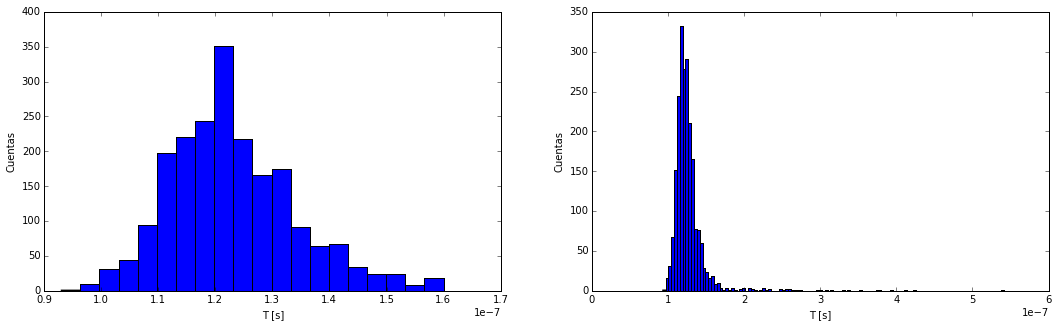

In [12]:
# tiempos de subida (risetime AMC)
taus= finales[:,0] # [s]
neufBin(taus, 0.15, 'T [s]')

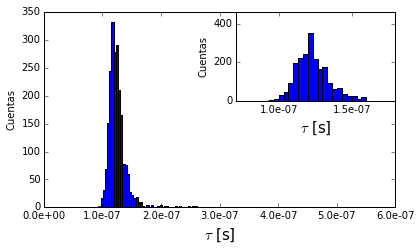

In [39]:
entrada= taus
corte= 0.15
unidad= '$\\tau$ [s]'
ancho= 16/2.54 # [in]

bins= 120
binHist=corte*bins
fig = plt.figure(figsize=(ancho,2*ancho*(5/18)))  # an empty figure with no axes
ax_lst= fig.add_subplot(1,1,1)
n, bins, patches= ax_lst.hist(entrada, bins)
ax_lst.set_ylabel('Cuentas')
ax_lst.set_xlabel(unidad,fontsize=15)

def func(x, pos):  # formatter function takes tick label and tick position
   s = '{:.1e}'.format(x)
   return s
x_format = tkr.FuncFormatter(func)  # make formatter
ax_lst.xaxis.set_major_formatter(x_format)  # set formatter to needed axis

intermedio = np.ma.masked_greater(entrada, bins[binHist])
primerCampana= intermedio.compressed()
ax_lst2= fig.add_subplot(2,2,2)
ax_lst2.set_ylabel('Cuentas')
ax_lst2.set_xlabel(unidad,fontsize=15)
ax_lst2.set_xlim(left=0.7E-7, right= 1.8E-7)
ax_lst2.set_ylim(top=460)
ax_lst2.xaxis.set_major_formatter(x_format)  # set formatter to needed axis
plt.locator_params(axis = 'x', nbins = 5)
plt.locator_params(axis = 'y', nbins = 3)
n_i, bins_i, patches_i= ax_lst2.hist(primerCampana, bins=20)
plt.savefig('../presentacion/graphs/taus150615z02.pgf')
plt.show()

(1528, 1.2189317633344248, 0.0015550304110479285)

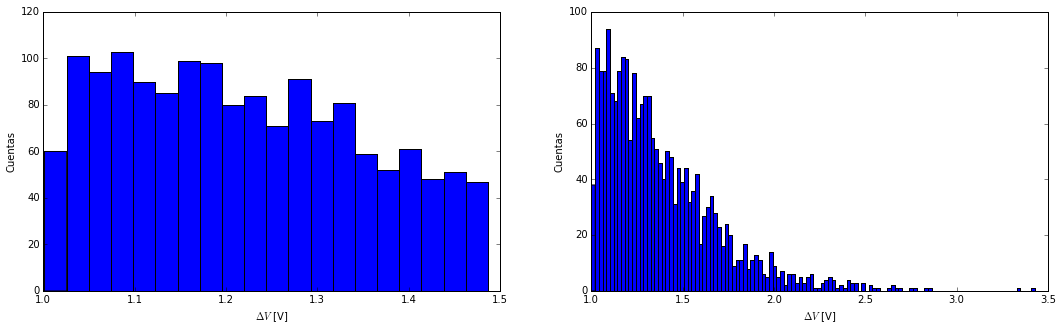

In [29]:
# máximo del pico AMC
maxs= finales[:,1] # [V]
neufBin(maxs, 0.2, '$\Delta V$ [V]')

(2135, 0.00024719118962350978, 6.3631287259313397e-08)

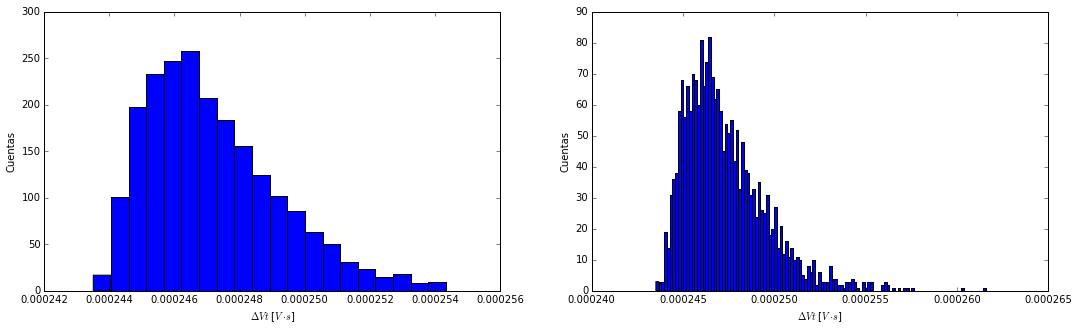

In [30]:
# Área de subida (hasta el pico AMC)
areaSubida= finales[:,2] # [Vs]
neufBin(areaSubida, 0.6, '$\Delta V t$ [$V\cdot s$]')

## Ar puro

In [31]:
# 150617z06
mes= 6
dia= 17
acqN= 6
npzData150617z06= np.load(dataPathFile(mes, dia, acqN))

finales150617z06= agrupadorTauMaxAreas(npzData150617z06)

# tiempos de subida (risetime AMC)
taus150617z06= finales150617z06[:,0] # [s]

(4023, 1.7276336067612497e-07, 2.8011160211264686e-10)

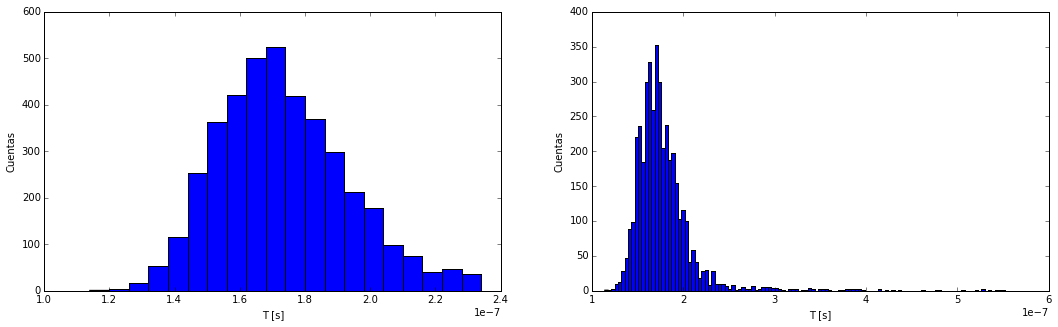

In [32]:
neufBin(taus150617z06, 0.28, 'T [s]')

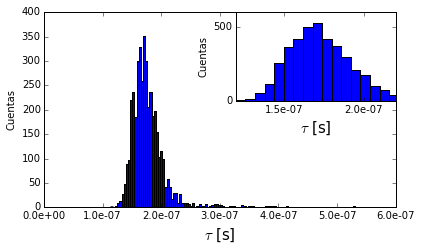

In [38]:
entrada= taus150617z06
corte= 0.28
unidad= '$\\tau$ [s]'
ancho= 16/2.54 # [in]

bins= 120
binHist=corte*bins
fig = plt.figure(figsize=(ancho,2*ancho*(5/18)))  # an empty figure with no axes
ax_lst= fig.add_subplot(1,1,1)
n, bins, patches= ax_lst.hist(entrada, bins)
ax_lst.set_ylabel('Cuentas')
ax_lst.set_xlabel(unidad,fontsize=15)
ax_lst.set_xlim(left=0, right= 6.0E-7)


def func(x, pos):  # formatter function takes tick label and tick position
   s = '{:.1e}'.format(x)
   return s
x_format = tkr.FuncFormatter(func)  # make formatter
ax_lst.xaxis.set_major_formatter(x_format)  # set formatter to needed axis

intermedio = np.ma.masked_greater(entrada, bins[binHist])
primerCampana= intermedio.compressed()
ax_lst2= fig.add_subplot(2,2,2)
ax_lst2.set_ylabel('Cuentas')
ax_lst2.set_xlabel(unidad,fontsize=15)

ax_lst2.set_xlim(left=1.2E-7, right= 2.2E-7)
ax_lst2.set_ylim(top=600)
ax_lst2.xaxis.set_major_formatter(x_format)  # set formatter to needed axis
plt.locator_params(axis = 'x', nbins = 4)
plt.locator_params(axis = 'y', nbins = 2)
n_i, bins_i, patches_i= ax_lst2.hist(primerCampana, bins=20)
plt.savefig('../presentacion/graphs/taus150617z06.pgf')